### Connect to Drive

In [181]:
#from google.colab import drive
#drive.mount('/gdrive')

In [182]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [183]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [184]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [185]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [186]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [187]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(validation_split=0.2, 
                                    #rescale=1/255.
                                   )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="validation",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [188]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [189]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]
    
    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    
    image = image*255
    
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


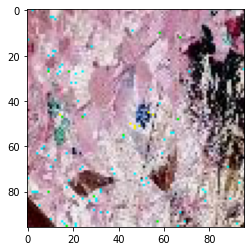

In [190]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

### Models metadata

In [191]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

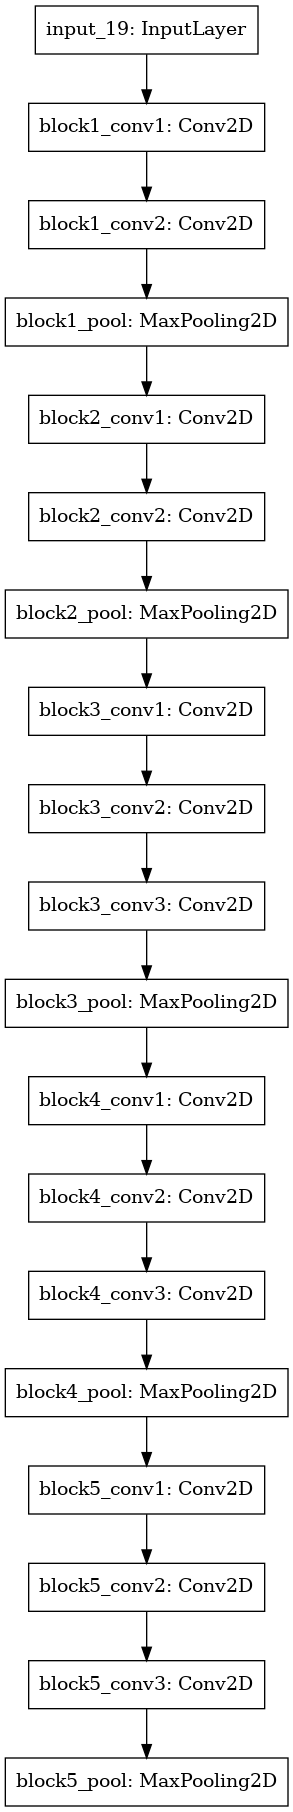

In [192]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# Use the supernet as feature extractor
supernet.trainable = False

supernet.summary()
tfk.utils.plot_model(supernet)

In [193]:
inputs = tfk.Input(shape=input_shape)
x = tfk.applications.vgg16.preprocess_input(inputs)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
Flattening (GlobalAveragePoo (None, 512)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328

In [194]:
# Train the model
history = tl_model.fit(
    x = train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
).history

Epoch 1/200
355/355 [==============================] - 6s 16ms/step - loss: 3.7032 - accuracy: 0.3202 - val_loss: 1.4123 - val_accuracy: 0.4943
Epoch 2/200
355/355 [==============================] - 5s 14ms/step - loss: 1.7747 - accuracy: 0.4154 - val_loss: 1.3277 - val_accuracy: 0.5411
Epoch 3/200
355/355 [==============================] - 5s 14ms/step - loss: 1.5186 - accuracy: 0.4520 - val_loss: 1.2503 - val_accuracy: 0.5411
Epoch 4/200
355/355 [==============================] - 5s 14ms/step - loss: 1.3816 - accuracy: 0.5011 - val_loss: 1.2104 - val_accuracy: 0.5694
Epoch 5/200
355/355 [==============================] - 5s 15ms/step - loss: 1.3045 - accuracy: 0.5324 - val_loss: 1.1773 - val_accuracy: 0.6076
Epoch 6/200
355/355 [==============================] - 5s 14ms/step - loss: 1.2770 - accuracy: 0.5391 - val_loss: 1.1489 - val_accuracy: 0.6105
Epoch 7/200
355/355 [==============================] - 5s 14ms/step - loss: 1.2031 - accuracy: 0.5603 - val_loss: 1.1328 - val_accuracy:

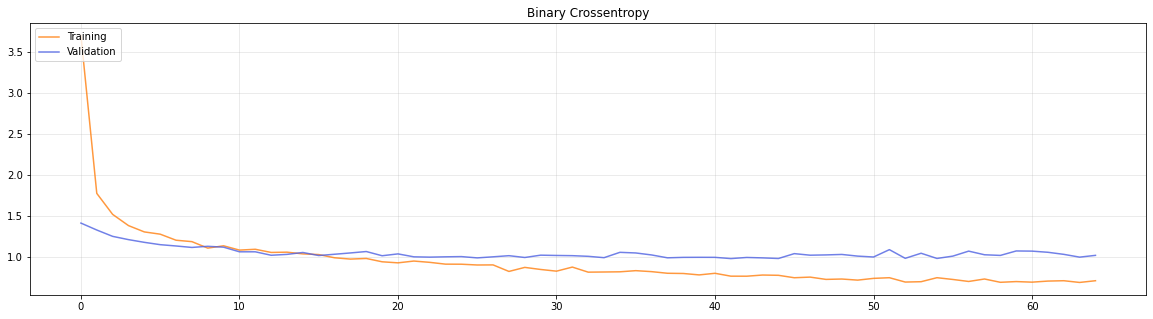

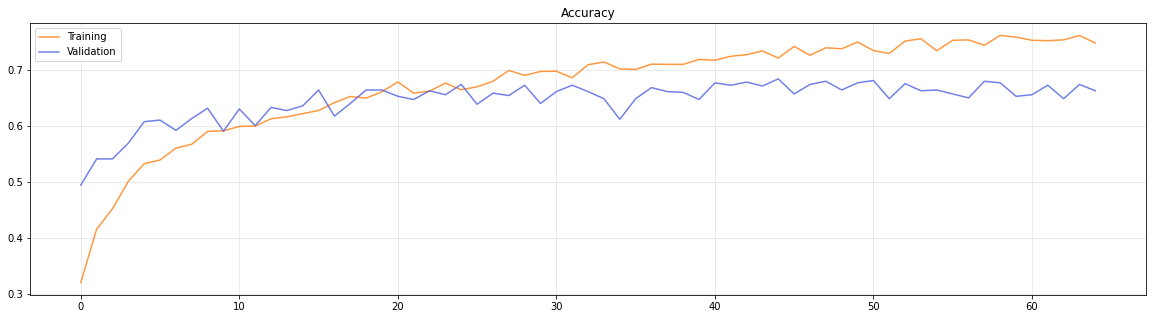

In [195]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [208]:
tl_model.save('ANN_Homework1_Model')

In [197]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_19 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [199]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_19 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688

In [201]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [202]:
# Fine-tune the model
ft_history = tl_model.fit(
    x = train_gen,
    batch_size = 64,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
355/355 [==============================] - 7s 17ms/step - loss: 1.5004 - accuracy: 0.4972 - val_loss: 1.1489 - val_accuracy: 0.5652
Epoch 2/200
355/355 [==============================] - 5s 15ms/step - loss: 1.2264 - accuracy: 0.5638 - val_loss: 1.1357 - val_accuracy: 0.5907
Epoch 3/200
355/355 [==============================] - 6s 16ms/step - loss: 1.0592 - accuracy: 0.6312 - val_loss: 1.0050 - val_accuracy: 0.6615
Epoch 4/200
355/355 [==============================] - 6s 15ms/step - loss: 0.9293 - accuracy: 0.6738 - val_loss: 1.0249 - val_accuracy: 0.6246
Epoch 5/200
355/355 [==============================] - 6s 17ms/step - loss: 0.7799 - accuracy: 0.7394 - val_loss: 0.9122 - val_accuracy: 0.6884
Epoch 6/200
355/355 [==============================] - 5s 15ms/step - loss: 0.6852 - accuracy: 0.7627 - val_loss: 0.8828 - val_accuracy: 0.6884
Epoch 7/200
355/355 [==============================] - 6s 16ms/step - loss: 0.5951 - accuracy: 0.7867 - val_loss: 0.8402 - val_accuracy:

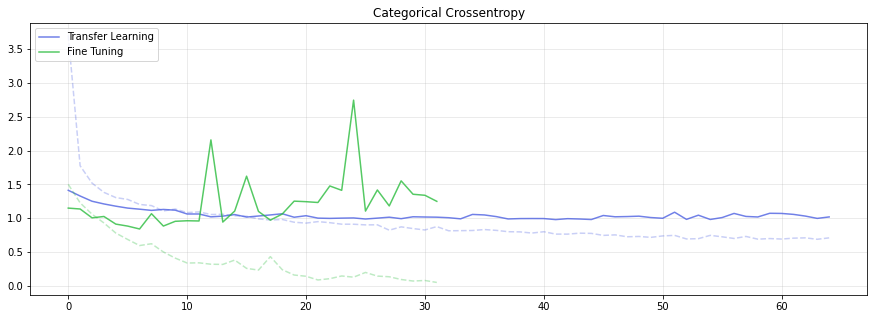

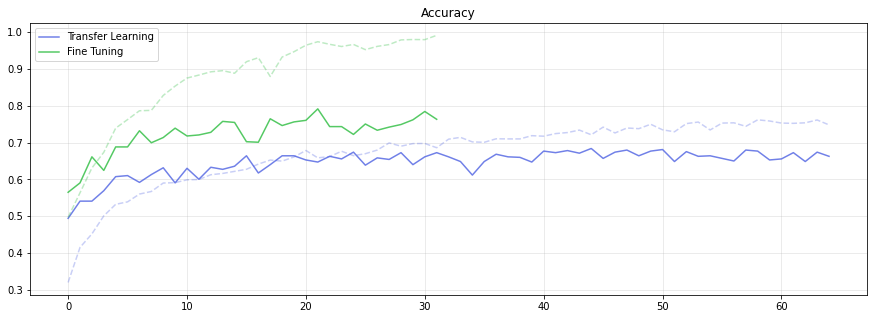

In [207]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [209]:
import shutil
tl_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

'/kaggle/working/ANN_Homework1_Model.zip'